In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
from scipy import special as ssp # fonction gamma
%matplotlib inline

# Calcul de Ff

In [70]:
def fourier_inverse(X,Xi,Ff):
    return (Xi[1]-Xi[0])*np.array([np.sum(Ff*np.exp(1j*x*Xi)) for x in X])/(2*np.pi)

def get_fourier_log_wt(Xi,Wt):
    return [np.mean(np.exp(-1j*xi*np.log(Wt[Wt>0]))) for xi in Xi]

In [24]:
def get_axi(wt,ximin,ximax,nbreaks_xi,tmax):
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot_four = ([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    tot_abs = np.log(np.abs(tot_four))
    tot_ang = np.angle(tot_four)
        
    # régression linéaire:
    res=[]
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot_abs)[:,k])
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(range(tmax),np.real(tot_ang)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        res+=[(Xi[k],slope,slope2,r_value,r_value2)]
        #print("pente :",slope, "\tpente angle :",slope2)
    # affichage:
    #plt.plot(range(tmax),tot_abs)
    #plt.grid()
    #plt.legend(["xi="+str(xi) for xi in Xi])
    #plt.xlabel("t")
    #plt.ylabel("ln[Fu_t(xi)]")
    #plt.title(titre)
    #plt.show() 
    return np.array(res)

# Calcul effectif de la DFE

In [25]:
xmin_reel=-2
xmax_reel=0.999
nbreaks_x=100
x=np.linspace(xmin_reel,xmax_reel,nbreaks_x)
lnx=np.log(1-x)

In [26]:
lambd=0.32/60 # constante biologique = taux de mutation

In [27]:
ncells=1452 # nombre de cellules utilisées pour les simulations
nreplicats=3 # nombre de simulations

La fonction suivante applique la formule de la dfe trouvée avec l'edp :

In [136]:
def get_dfe(wt,lnx,lambd,ximin,ximax,nbreaks_xi):
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(wt,ximin,ximax,nbreaks_xi,tmax=50).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    print(np.abs(Ff))
    y=fourier_inverse(lnx,Xi,Ff)
    return y

# Réplications sur différentes simulations

- Distribution initiale des taux de croissances

In [29]:
data = "cleaned"    # "raw" data or "cleaned" data (without dead cells and aberrant growth rates)

if data == "raw":
    file="Donnees_article/All_data/data_microMA/dataset_microMA_MutH.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",", 
                          usecols=range(2,1476*3+1,3), 
                          skiprows=[1,2])

elif data == "cleaned":
    file="Donnees_article_modifiees/data_microMA/dataset_microMA_MutH_growthRates_NAdead_NAab.csv"
    growthR_real = pd.read_csv(file, 
                          sep = ";", 
                          decimal=",")

growthR_real = growthR_real.to_numpy()


In [30]:
growthR_init = [np.median([l for l in d if not np.isnan(l)]) for d in growthR_real.T[:,:10]]   # médiane des 10 premières mesures

# on augmente la taille de growthR_init:
growthR_init=growthR_init*100
growthR_init=np.array(growthR_init[:ncells])

growthR_init[growthR_init<0] = 0          # retirer la valeur de taux de croissance négative aberrante
growthR_init[np.isnan(growthR_init)] = 0          # retirer les nan

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- Paramètres utilisés pour la simulation

In [93]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
exp_duration = 200        # durée de l'expérience, en minutes // modifié pour être plus rapide !
#exp_duration = 4000
mut_shape = (50+int(exp_duration*mutation_rate*10), ncells)  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)
constant_mut_rate = False # on choisit si le taux de mutation est constant

# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, exp_duration, 4, dtype=float)

# Bruit sur les mesures
sd_noise = 0.15           # Écart-type bruit additif gaussien

- Tirer dans une DFE donnée l'effet relatif de chacune des mutations sur le taux de croissance

In [98]:
# rappel des valeurs de l'article
#alpha=0.0074
#beta=2.4


# PARAMÈTRES TESTS

alpha=10
beta=10

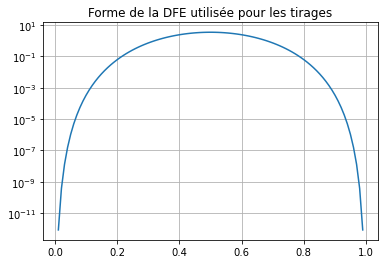

In [99]:
zar=np.linspace(0.01,0.99,100)
plt.yscale('log')
plt.grid()
plt.title("Forme de la DFE utilisée pour les tirages")
dfe_reelle_sim=[z**(alpha-1)*(1-z)**(beta-1)*ssp.gamma(alpha+beta)/(ssp.gamma(alpha)*ssp.gamma(beta)) for z in zar]
plt.plot(zar,dfe_reelle_sim)
plt.show()

- Fonctions réalisant la simulation

In [96]:
def average_by_generation(growthR, sd_noise=0):
    # Cumulative growth of the cell (exponential coefficient = growth rate x (nbPictures x 4min/picture))
    cum_growth = np.cumsum(growthR*4, axis=0)
    # Total growth at the end of the experiment
    final_growth = cum_growth[-1]
    # The cell divides each time it doubles in size, i.e. every ln(2) increase in growth coefficient
    divisions = np.arange(final_growth//np.log(2)+2)*np.log(2)
    # Generation = interval between between 2 divisions
    generations_masks = [np.logical_and(cum_growth>=divisions[i-1], cum_growth<divisions[i]) for i in range(1,len(divisions))]
    # Length of each generation
    generation_lengths = np.sum(generations_masks, axis=1)
    # Add multiplicative measurement noise (facultative)
    if sd_noise != 0 :
        growthR = growthR*(1+np.random.normal(0, sd_noise, size=np.shape(growthR)))
    # Average the growth rates during each generation
    growthR_genAverage = [np.mean(growthR[generation]) for generation in generations_masks]
    return (np.repeat(growthR_genAverage, repeats=generation_lengths))

def sim_B_growth (growthR_init, dty_mix, dty_weights, mut_shape, sd_noise, constant_mut_rate, mutation_rate, seed=np.random.randint(10000)):
    """Simule des expériences de croissance bactérienne

    Parameters:
    growthR_init (array): taux de croissance initiaux (pour chaque microcanal)
    dty_mix (tuple): mélange de densités représentant la DFE
    dty_weights (tuple): poids de chacune des densités
    mut_shape (tuple): forme du tableau des taux de croissance en sortie (nombre de mesures x nombre de canaux)
    sd_noise (float): écart-type du bruit Gaussien sur les mesures
    constant_mut_rate (bool): si Vrai le taux de mutation est constant, sinon il dépend du taux de croissance
    mutation_rate (float): taux de mutation
    seed (float): graîne pour les générateurs aléatoires 

    Returns:
    int:Returning value

   """
    
    np.random.seed(seed)
    
    # DFE
    s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=dty_weights, size=mut_shape), choices = dty_mix)

    # Effets relatifs des mutations sur la fitness
    fitness_effects = (1 - s)
    
    # Effets relatifs cumulés des mutations
    cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)
    
    # Évolution du taux de croissance, mutation par mutation
    growthR_steps_sim = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init))
        
    # Durées entre 2 mutations
    if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
        exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
        mutation_rate_t = growthR_steps_sim[:-1]/np.mean(growthR_init) * mutation_rate
        exponential_intervals = np.random.exponential(1/mutation_rate_t)
        exponential_intervals[np.isinf(exponential_intervals)] = exp_duration
    # Temps d'apparition de chaque mutation
    mutation_time = np.cumsum(exponential_intervals, axis=0)
    # Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
    assert min(mutation_time[-1,:]) > exp_duration, "Ajouter plus de mutations, simulations trop courtes : " + str(mutation_time[:,mutation_time[-1,:]<exp_duration])
    
    # Évolution du taux de croissance au cours du temps
    growthR_sim = []
    for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
        # Identifier après quelle mutation la mesure est faite
        cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
        # Prendre la valeur de taux de croissance associé à cette mutation
        growthR_sim.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim[1:,i]))

    growthR_sim = np.array(growthR_sim).T
    #growthR_sim_noise = growthR_sim*(1+np.random.normal(0, sd_noise, size=np.shape(growthR_sim)))
    growthR_sim_noise = np.array([average_by_generation(growthR, sd_noise) for growthR in growthR_sim.T]).T
    
    return ([growthR_sim, growthR_sim_noise])


# Combiner différentes densités pour former une DFE mixte
dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
           np.ones(mut_shape))                               # mutations létales
dty_weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité


Attention: désactivation du assert qui bloquait tout; certaines expériences seront trop courtes

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


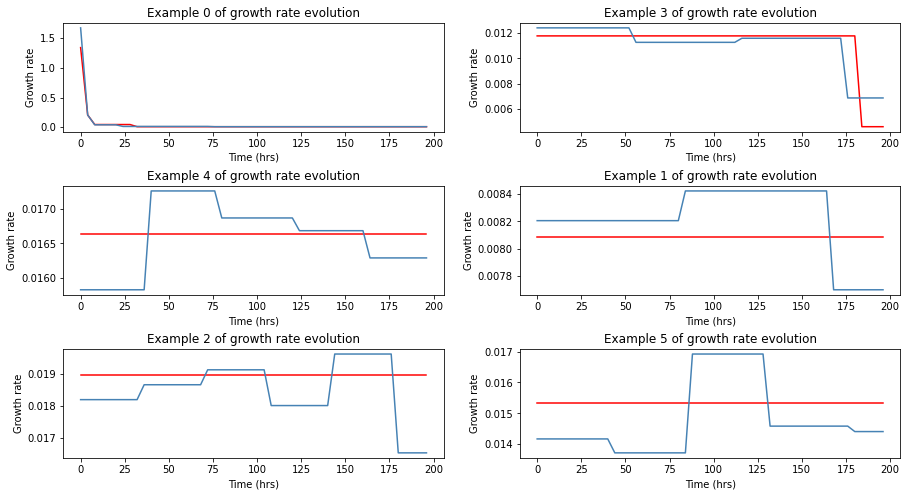

In [113]:
replicates = [sim_B_growth(growthR_init, dty_mix, dty_weights, mut_shape, sd_noise, 
                           constant_mut_rate, mutation_rate, seed=k) for k in range(nreplicats)]
growthR_sim_replicates = np.array(replicates)[:,0]
growthR_sim_noise_replicates = np.array(replicates)[:,1]

fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
for i in range(6) :
    ax[i%3,i%2].plot(time, growthR_sim_replicates[0,:,i], color="r")
    ax[i%3,i%2].plot(time, growthR_sim_noise_replicates[0,:,i], color="steelblue")
    ax[i%3,i%2].set(xlabel = "Time (hrs)", ylabel = "Growth rate", title = "Example "+str(i)+" of growth rate evolution")

In [130]:
draw_log_log(growthR_sim_replicates[1],ximin=0.1,ximax=5,nbreaks_xi=10,tmax=1000,n_renorm=1,titre="Données simulées : LOG")

IndexError: index 50 is out of bounds for axis 0 with size 50

In [131]:
draw_log_log(growthR_sim_noise_replicates[1],ximin=0.1,ximax=5,nbreaks_xi=10,tmax=1000,n_renorm=1,titre="Données simulées : LOG")

IndexError: index 50 is out of bounds for axis 0 with size 50

[ 1.          1.00010039  1.0004015   1.00090318  1.00160515  1.00250705
  1.00360839  1.0049086   1.00640698  1.00810276  1.00999506  1.01208291
  1.01436524  1.0168409   1.01950864  1.02236715  1.02541503  1.02865081
  1.03207295  1.03567983  1.0394698   1.04344111  1.04759199  1.05192061
  1.05642509  1.06110352  1.06595394  1.07097438  1.0761628   1.08151719
  1.08703548  1.09271559  1.09855545  1.10455295  1.110706    1.11701248
  1.1234703   1.13007735  1.13683155  1.14373081  1.15077306  1.15795624
  1.1652783   1.17273724  1.18033104  1.18805773  1.19591535  1.20390197
  1.21201568  1.22025462  1.22861693  1.2371008   1.24570445  1.25442611
  1.26326408  1.27221665  1.28128217  1.29045902  1.29974561  1.30914039
  1.31864182  1.32824843  1.33795876  1.34777139  1.35768493  1.36769801
 15.99645442 29.71544335 34.22290329 32.22705781 26.10354474 13.82372606
  1.44046994  1.45123445  1.46208771  1.47302867  1.48405631  1.49516962
  1.50636763  1.51764938  1.52901396  1.54046045  1

[ 1.          1.00274241  1.01093223  1.02446041  1.04315501  1.06679419
  1.09512152  1.12786133  1.16473281  1.20546163  1.24978869  1.29747598
  1.34830995  1.40210282 26.04249335  1.51793986  1.57972922  1.64396311
  1.71056068  1.77945466  1.85058844  1.9239134   1.99938641  2.07696749
  2.15661771  2.23829729  2.32196392  2.40757122  2.49506734  2.58439373
  2.67548393  2.76826244  2.86264354  2.95853013  3.05581236  3.1543662
  3.25405174  3.35471122  3.45616671  3.5582174   3.6606364  24.96873728
 31.70438709 27.14690106 13.42720476  4.16797084  4.26583156  4.36135642
  4.45392953  4.54285912  4.62737354  4.7066201   4.77966833  4.84551962
  4.90312511  4.9514141   4.98933411  5.01590281  5.03026968  5.03178263
  5.02005216  4.99500343  4.9569072   4.90638264  4.84437033  4.77207928
  4.69091663  4.60241117  4.50814112  4.4096739   4.30852205  4.20611586
  4.10379094  4.00278773  6.79001537 14.70266707  3.71888216  3.63402899
  3.55567102  3.48473603  3.42214086  3.36879464  3.

[ 1.          1.0109108   1.04303464  1.09472758  1.16374628  1.24771352
  1.34444901 28.55811034  1.56929774  1.69484145  1.82788185  1.96770318
  2.1136731   2.26517965  2.42158194  2.58217216  2.74614538  2.91257259
  3.08037281  3.24828044  3.4148055  31.67021854 13.50681237  3.88681573
  4.02675946  4.15292685  4.26174828  4.34949467  4.41256823  4.4479285
  4.45361439  4.42925358  4.37639453  4.29850937  4.20062204  4.08866557
  3.96876766 31.66208829  3.72725278  3.61454829  3.51155915  3.42045349
  3.34271017  3.27931656  3.23099477  3.19846077  3.18271909  3.18537813
  3.20893581  3.25694212  3.33392522  3.44501641  3.59534037 27.97820913
 14.03366627  4.3216646   4.66447043  5.06130185  5.51533079  6.03132474
  6.6160444   7.27788092  8.02420243  8.85416712  9.74472909 10.38662825
  9.55849258  8.76136122  7.40955521  6.06198869  4.96346073  5.65630215
  6.69027339  3.26564006  2.43598579  2.00225403  1.74854534  1.7409979
  1.98859018  2.43459523  3.02298201  4.1799653   5.4

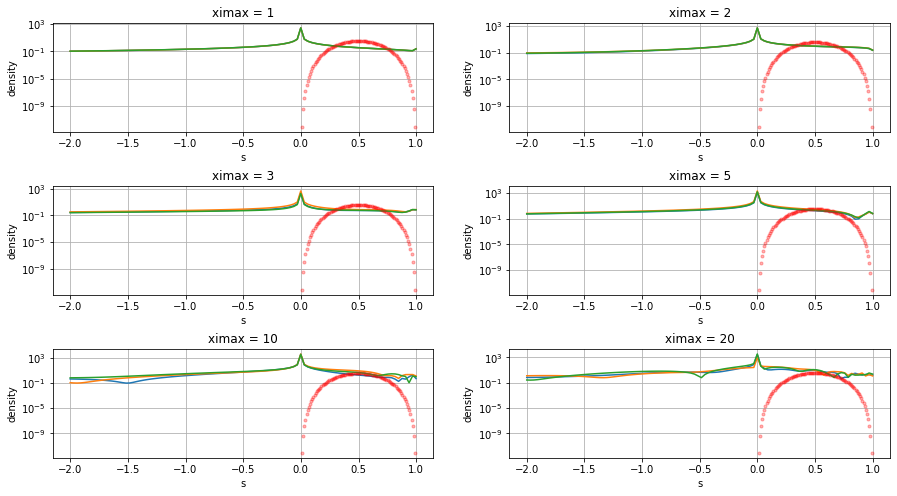

In [137]:
fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    dfeln=[]
    dfe=[]
    for i,ximax in enumerate([1,5,10,2,3,20]):
        dfeln+=[get_dfe(growthR_sim_noise_i,lnx,lambd,ximin=0,ximax=ximax,nbreaks_xi=100)]
        dfe+=[[dfeln[i][j]/x[j] for j in range(len(x))]]
        ax[i%3,i%2].plot(x,np.abs(dfe[i]))
        ax[i%3,i%2].plot(zar,dfe_reelle_sim,'.', c="r", alpha=1/(3*nreplicats))
        ax[i%3,i%2].grid()
        ax[i%3,i%2].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

KeyboardInterrupt: 

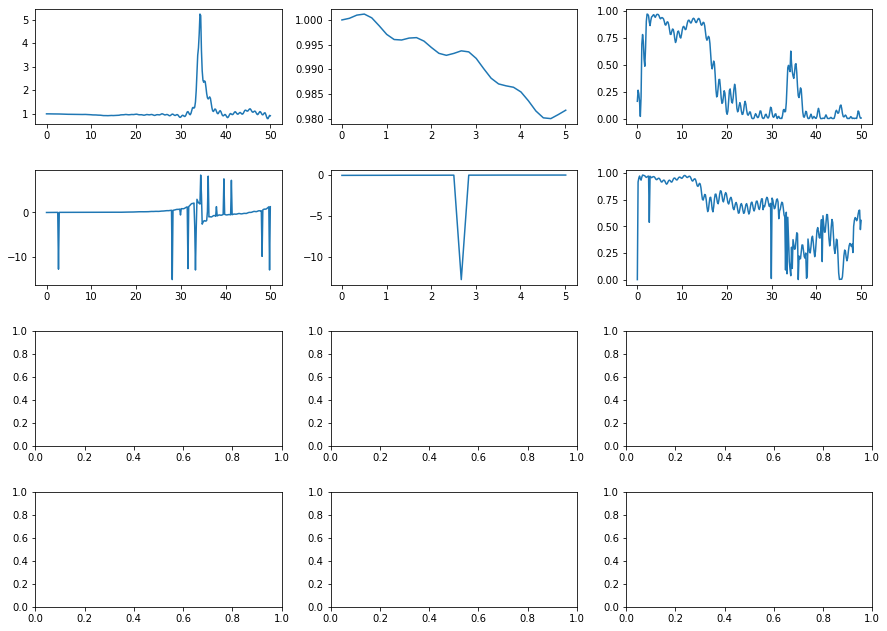

In [20]:
ximin=0
ximax=50
nbreaks_xi=300

xi_cut = int(5*nbreaks_xi/ximax+1)    # Zoom sur [0,5]

im, ax = plt.subplots(4,3, figsize=(15,11))
im.subplots_adjust(hspace=0.4)

for growthR_sim_i in growthR_sim_replicates:
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_i,ximin,ximax,nbreaks_xi,tmax=100).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    ax[0,0].plot(Xi,1+np.real(a_xi)/lambd)
    ax[1,0].plot(Xi,np.imag(a_xi)/lambd)
    ax[0,1].plot(Xi[:xi_cut],1+np.real(a_xi[:xi_cut])/lambd)
    ax[1,1].plot(Xi[:xi_cut],np.imag(a_xi[:xi_cut])/lambd)
    ax[0,2].plot(Xi,ReFit**2)
    ax[1,2].plot(Xi,ImFit**2)

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_noise_i,ximin,ximax,nbreaks_xi,tmax=100).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    ax[2,0].plot(Xi,1+np.real(a_xi)/lambd)
    ax[3,0].plot(Xi,np.imag(a_xi)/lambd)
    ax[2,1].plot(Xi[:xi_cut],1+np.real(a_xi[:xi_cut])/lambd)
    ax[3,1].plot(Xi[:xi_cut],np.imag(a_xi[:xi_cut])/lambd)
    ax[2,2].plot(Xi,ReFit**2)
    ax[3,2].plot(Xi,ImFit**2)

[[axij.grid() for axij in axi] for axi in ax]
ax[0,0].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. non bruitées")
ax[1,0].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. non bruitées")
ax[0,1].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. non bruitées")
ax[1,1].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. non bruitées")
ax[0,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie réelle : sim. non bruitées")
ax[1,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie imaginaire : sim. non bruitées")
ax[2,0].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. bruitées")
ax[3,0].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. bruitées")
ax[2,1].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. bruitées")
ax[3,1].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. bruitées")
ax[2,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie réelle : sim. bruitées")
ax[3,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie imaginaire : sim. bruitées")
plt.show()

In [ ]:
ximin=0
ximax=50
nbreaks_xi=300

xi_cut = int(5*nbreaks_xi/ximax+1)    # Zoom sur [0,5]

im, ax = plt.subplots(4,3, figsize=(15,11))
im.subplots_adjust(hspace=0.4)

for growthR_sim_i in growthR_sim_replicates:
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_i,ximin,ximax,nbreaks_xi,tmax=1000).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    ax[0,0].plot(Xi,1+np.real(a_xi)/lambd)
    ax[1,0].plot(Xi,np.imag(a_xi)/lambd)
    ax[0,1].plot(Xi[:xi_cut],1+np.real(a_xi[:xi_cut])/lambd)
    ax[1,1].plot(Xi[:xi_cut],np.imag(a_xi[:xi_cut])/lambd)
    ax[0,2].plot(Xi,ReFit**2)
    ax[1,2].plot(Xi,ImFit**2)

for growthR_sim_noise_i in growthR_sim_noise_replicates:
    Xi, Reaxi, Imaxi, ReFit, ImFit = get_axi(growthR_sim_noise_i,ximin,ximax,nbreaks_xi,tmax=1000).T
    a_xi = Reaxi + 1j*Imaxi
    Ff=a_xi/lambd+1
    
    ax[2,0].plot(Xi,1+np.real(a_xi)/lambd)
    ax[3,0].plot(Xi,np.imag(a_xi)/lambd)
    ax[2,1].plot(Xi[:xi_cut],1+np.real(a_xi[:xi_cut])/lambd)
    ax[3,1].plot(Xi[:xi_cut],np.imag(a_xi[:xi_cut])/lambd)
    ax[2,2].plot(Xi,ReFit**2)
    ax[3,2].plot(Xi,ImFit**2)

[[axij.grid() for axij in axi] for axi in ax]
ax[0,0].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. non bruitées")
ax[1,0].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. non bruitées")
ax[0,1].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. non bruitées")
ax[1,1].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. non bruitées")
ax[0,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie réelle : sim. non bruitées")
ax[1,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie imaginaire : sim. non bruitées")
ax[2,0].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. bruitées")
ax[3,0].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. bruitées")
ax[2,1].set(xlabel="xi", ylabel="Re(a_xi)/lambda+1", title="Variations partie réelle : sim. bruitées")
ax[3,1].set(xlabel="xi", ylabel="Im(a_xi)/lambda", title="Variations partie imaginaire : sim. bruitées")
ax[2,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie réelle : sim. bruitées")
ax[3,2].set(xlabel="xi", ylabel="Coefficient de corrélation", title="R2 partie imaginaire : sim. bruitées")
plt.show()

$\to$ il y a toujours du bruit, mais qui semble plus facile à gérer (par exemple, en comparant à la médiane).

# Vérification qu'on ne fait pas n'importe quoi

Tests sur différentes valeurs de $\xi$

In [117]:
def draw_log_log(wt,ximin,ximax,nbreaks_xi,tmax,n_renorm=0,titre=""):
    
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot = np.abs([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    if n_renorm > 0 :    # number of initial growth rate measures considered to renormalise
        tot = tot/np.median(tot[:n_renorm,:], axis=0)
    
    tot = np.log(tot)
        
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("ln|Fu_t(xi)|")
    plt.title(titre)
    plt.show() 

def draw_log_arg(wt,ximin,ximax,nbreaks_xi,tmax,n_renorm=0,titre=""):
    
    Xi = np.linspace(ximin,ximax,nbreaks_xi)
    tot = np.array([get_fourier_log_wt(Xi,wt[t]) for t in range(tmax)])
    
    if n_renorm > 0 :    # number of initial growth rate measures considered to renormalise
        tot = tot/np.median(tot[:n_renorm,:], axis=0)
    
    tot = np.angle(tot)
        
    # régression linéaire:
    for k in range(nbreaks_xi):
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
        #plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
        print("pente :",slope)
    # affichage:
    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xi) for xi in Xi])
    plt.xlabel("t")
    plt.ylabel("arg[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

In [118]:
wt_sim=growthR_sim_replicates[1]
#wt_sim=growthR_sim_noise_replicates[0]


pente : -4.312482432981861e-05
pente : -0.0017569937980170909
pente : -0.005775045676415903
pente : -0.011849258845380073
pente : -0.018802887156432718
pente : -0.02375145131039472
pente : -0.025369328275474397
pente : -0.0239897302818111
pente : -0.023320745810555397
pente : -0.024748426890413892


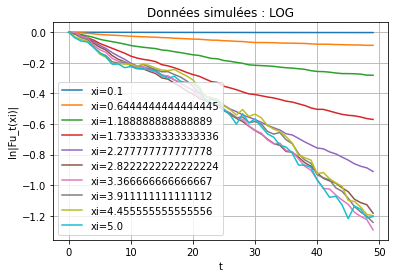

In [119]:
draw_log_log(wt_sim,ximin=0.1,ximax=5,nbreaks_xi=10,tmax=50,n_renorm=1,titre="Données simulées : LOG")

$\to$ Ne fonctionne pas bien longtemps... Est-ce que c'est parce qu'il y a trop de mutations beaucoup trop délétères ?

pente : -0.024748426890413892
pente : -0.03541735042417042
pente : -0.03422815747865291
pente : -0.011176977346522196
pente : -0.0023811052407013817
pente : -0.010029831953123538
pente : -0.007296264903362802
pente : 0.0057785466390067744
pente : 0.0006260843282381026
pente : -0.0013830059660571046


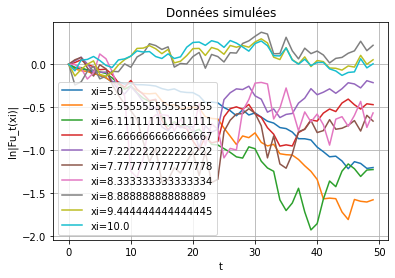

In [120]:
draw_log_log(wt_sim,ximin=5,ximax=10,nbreaks_xi=10,tmax=50,n_renorm=1,titre="Données simulées")

pente : -0.0013830059660571046
pente : 0.027695254161977562
pente : 0.026725645751824647
pente : -0.017667340349169797
pente : -0.006218610926156007


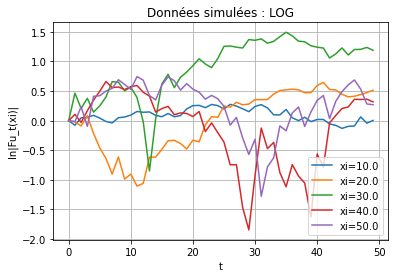

In [121]:
draw_log_log(wt_sim,ximin=10,ximax=50,nbreaks_xi=5,tmax=50,n_renorm=1,titre="Données simulées : LOG")

pente : 0.0011833076755084914
pente : 0.013445527327331792
pente : 0.013375660554468427
pente : 0.0037610138136576904
pente : 0.0047583860102385234


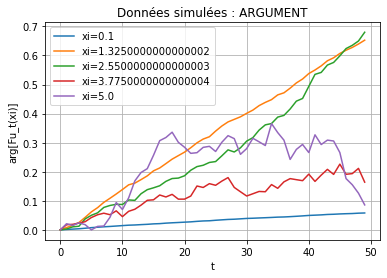

In [122]:
draw_log_arg(wt_sim,ximin=0.1,ximax=5,nbreaks_xi=5,tmax=50,n_renorm=1,titre="Données simulées : ARGUMENT")

pente : 0.00854706376761483
pente : -0.024501403812097155
pente : 0.0030583367050483696
pente : -0.00898275578927605
pente : -0.0377418712175045


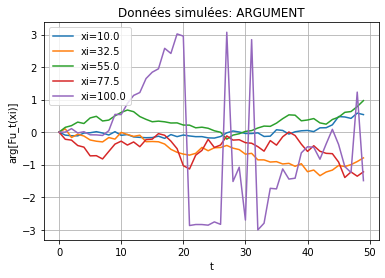

In [123]:
draw_log_arg(wt_sim,ximin=10,ximax=100,nbreaks_xi=5,tmax=50,n_renorm=1,titre="Données simulées: ARGUMENT")

# Bruit au cours du temps

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


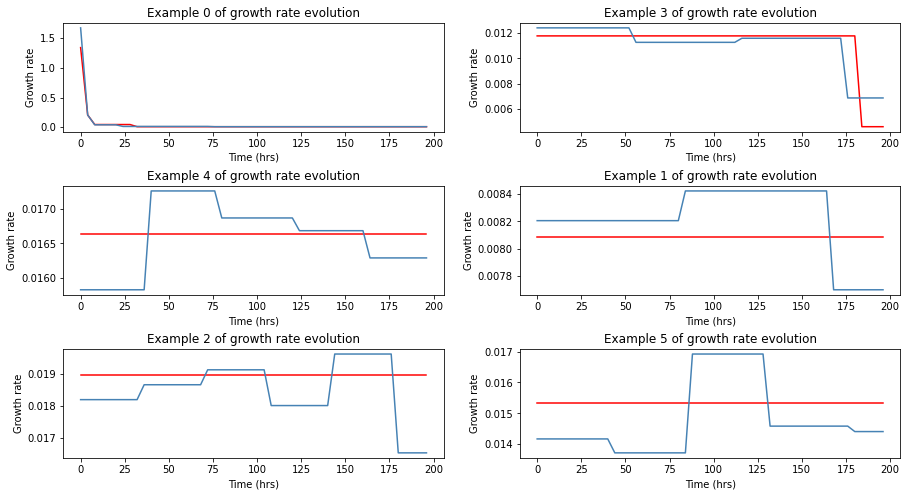

In [124]:
replicates = [sim_B_growth(growthR_init, dty_mix, dty_weights, mut_shape, sd_noise, 
                           constant_mut_rate, mutation_rate, seed=k) for k in range(nreplicats)]
growthR_sim_replicates = np.array(replicates)[:,0]
growthR_sim_noise_replicates = np.array(replicates)[:,1]

fig, ax = plt.subplots(3,2, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
for i in range(6) :
    ax[i%3,i%2].plot(time, growthR_sim_replicates[0,:,i], color="r")
    ax[i%3,i%2].plot(time, growthR_sim_noise_replicates[0,:,i], color="steelblue")
    ax[i%3,i%2].set(xlabel = "Time (hrs)", ylabel = "Growth rate", title = "Example "+str(i)+" of growth rate evolution")

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


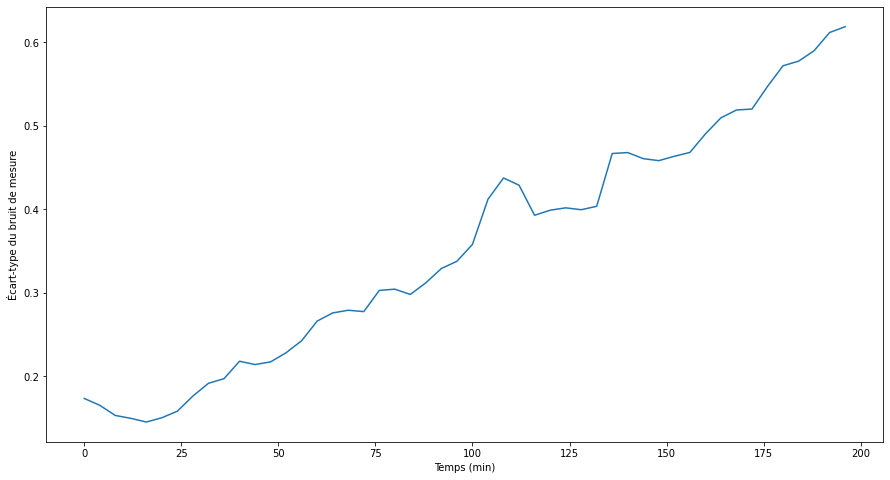

In [125]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
noise = growthR_sim_noise_replicates/growthR_sim_replicates
noise[noise==np.inf]=np.nan
ax.plot(time, np.nanstd(noise[0], axis=1))
ax.set(xlabel="Temps (min)", ylabel="Écart-type du bruit de mesure")
plt.show()

/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


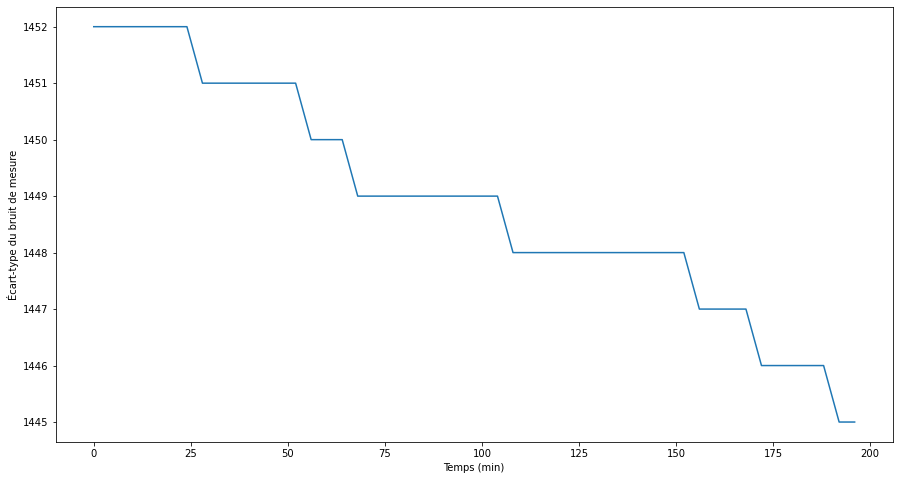

In [126]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
noise = growthR_sim_noise_replicates/growthR_sim_replicates
noise[noise==np.inf]=noise[1,-1,:][0]
ax.plot(time, np.sum(noise[1]!=noise[1,-1,:][0], axis=1))
ax.set(xlabel="Temps (min)", ylabel="Écart-type du bruit de mesure")
plt.show()

# Norme $L^1$

In [127]:
def cdf_l1(dist1,dist2,corr,tronc):
    cdf1=np.cumsum(dist1[1+tronc:])
    cdf2=np.cumsum(dist2[1+tronc:])
    if(len(cdf1)!=len(cdf2)):
        print("Attention: longueurs différentes",len(cdf1),len(cdf2))
    return np.sum([np.abs(corr*cdf1[i]-cdf2[i]) for i in range(len(cdf1))])*(xmax_reel-xmin_reel)/len(x)

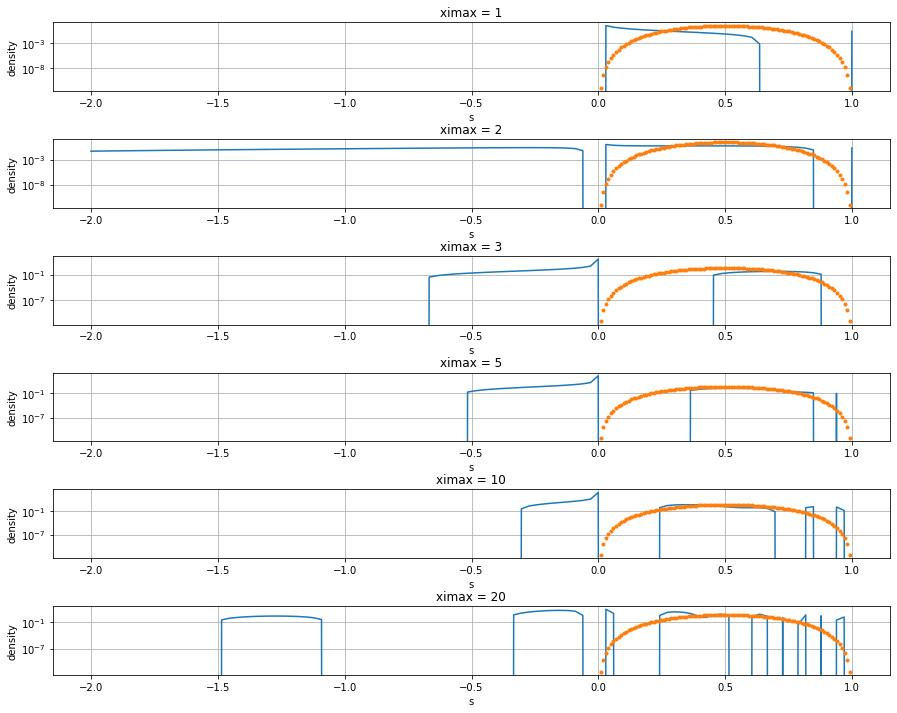

In [128]:
fig, ax = plt.subplots(6,1, figsize=(15,12))
fig.subplots_adjust(hspace=0.7)
dfeln=[]
dfe=[]
for i,ximax in enumerate([1,2,3,5,10,20]):
    dfeln+=[get_dfe(growthR_sim_replicates[0],lnx,lambd,ximin=0,ximax=ximax,nbreaks_xi=100)]
    dfe+=[[dfeln[i][j]/x[j] for j in range(len(x))]]
    ax[i].plot(x,np.real(dfe[i]))
    ax[i].plot(zar,dfe_reelle_sim,'.')
    ax[i].grid()
    ax[i].set(title="ximax = " + str(ximax), yscale='log', xlabel="s", ylabel="density")
    
plt.show()

In [129]:
print("Norme tronquée de la vraie DFE :",cdf_l1([0]*100,dfe_reelle_sim,corr=1,tronc=20))
for i in range(6):
    print("Distance tronquée entre la ",i+1,"e DFE estimée et la vraie DFE :",cdf_l1(dfe[i],dfe_reelle_sim,corr=6.28,tronc=20))

# NB: terme corr: correction pour que les dfe comparées aient à peu près la même échelle.
# tronc: on tronque le début car on ne repère pas le gros pic très fin passe mal à la discrétisation

Norme tronquée de la vraie DFE : 152.3527216892504
Distance tronquée entre la  1 e DFE estimée et la vraie DFE : 2098.1549446699764
Distance tronquée entre la  2 e DFE estimée et la vraie DFE : 2276.739738876757
Distance tronquée entre la  3 e DFE estimée et la vraie DFE : 3193.988457700672
Distance tronquée entre la  4 e DFE estimée et la vraie DFE : 10920.100360574557
Distance tronquée entre la  5 e DFE estimée et la vraie DFE : 28284.12370965961
Distance tronquée entre la  6 e DFE estimée et la vraie DFE : 26863.697218033063


NB: on trouve de meilleurs résultats avec ncells=10... (pour la distance L1: dmin=0.12 avec corr=2pi)

PB avec corr : pourquoi est-il nécessaire pour avoir des résultats potables ?